# This notebook plots various MCS track statistics KDE over a specified region and period

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
%matplotlib inline

In [2]:
# Dictionary for official model names
model_name = {
    'obs': 'OBS',
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

region = 'tropics'
lon_bounds = [0, 360]
lat_bounds = [-20, 15]
lifetime_bounds = [2,60]
# sdate = '2020-02-01T00'
sdate = '2020-01-25T00'
edate = '2020-03-01T00'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

test = ''
# test = '_ccs1_2h'
rootdir = '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/'
obsfile = f'{obsdir}mcs_tracks_final_20200120.0000_20200301.0000.nc'

name_map = {
    'obs': 'obs',
    'm1': 'mpi',
    'm2': 'scream',
    'm3': 'nasa',
    'm4': 'nicam',
    'm5': 'noaa',
    'm6': 'uk',
}
m1dir = f'{rootdir}{name_map["m1"]}/stats{test}/'
m2dir = f'{rootdir}{name_map["m2"]}/stats{test}/'
m3dir = f'{rootdir}{name_map["m3"]}/stats{test}/'
m4dir = f'{rootdir}{name_map["m4"]}/stats{test}/'
m5dir = f'{rootdir}{name_map["m5"]}/stats{test}/'
m6dir = f'{rootdir}{name_map["m6"]}/stats{test}/'
m1file = f'{m1dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m2file = f'{m2dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m3file = f'{m3dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m4file = f'{m4dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m5file = f'{m5dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m6file = f'{m6dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'

# figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
figdir = f'/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures/


In [3]:
obsfile, m1file, m2file, m3file, m4file, m5file, m6file

('/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/obs/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/mpi/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/scream/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/nasa/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/nicam/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/noaa/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/uk/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc')

## Custom functions for track selections

In [4]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track initiation location
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_basetime >= pd.to_datetime(sdate)) & (start_basetime <= pd.to_datetime(edate)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

In [5]:
# Read OBS MCS data
dsobs = xr.open_dataset(obsfile)
time_res_obs = dsobs.attrs['time_resolution_hour']
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
dsobs

<xarray.Dataset>
Dimensions:                  (tracks: 3068, times: 200, mergers: 200, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 3064 3065 3066 3067
  * times                    (times) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * mergers                  (mergers) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Sat Feb 12 17:42:48 2022
    startdate:                   20200120.0000
    enddate:                     20200301.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [6]:
# Read m1 data
dsm1 = xr.open_dataset(m1file)
time_res_m1 = dsm1.attrs['time_resolution_hour']
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']

In [7]:
# Read m2 data
dsm2 = xr.open_dataset(m2file)
time_res_m2 = dsm2.attrs['time_resolution_hour']
pixel_radius_m2 = dsm2.attrs['pixel_radius_km']

In [8]:
# Read m3 data
dsm3 = xr.open_dataset(m3file)
time_res_m3 = dsm3.attrs['time_resolution_hour']
pixel_radius_m3 = dsm3.attrs['pixel_radius_km']

In [9]:
# Read m4 data
dsm4 = xr.open_dataset(m4file)
time_res_m4 = dsm4.attrs['time_resolution_hour']
pixel_radius_m4 = dsm4.attrs['pixel_radius_km']

In [10]:
# Read m5 data
dsm5 = xr.open_dataset(m5file)
time_res_m5 = dsm5.attrs['time_resolution_hour']
pixel_radius_m5 = dsm5.attrs['pixel_radius_km']

In [11]:
# Read m6 data
dsm6 = xr.open_dataset(m6file)
time_res_m6 = dsm6.attrs['time_resolution_hour']
pixel_radius_m6 = dsm6.attrs['pixel_radius_km']

## Find tracks by time, region, lifetime

In [12]:
# OBS
mcsidx_obs = find_track_in_region(dsobs.start_basetime, dsobs.meanlon, dsobs.meanlat, dsobs.track_duration*time_res_obs, lon_bounds, lat_bounds, lifetime_bounds)
print('Number of MCS (OBS): ', len(mcsidx_obs))

# Model m1
mcsidx_m1 = find_track_in_region(dsm1.start_basetime, dsm1.meanlon, dsm1.meanlat, dsm1.track_duration*time_res_m1, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m1"]}): ', len(mcsidx_m1))

# Model m2
mcsidx_m2 = find_track_in_region(dsm2.start_basetime, dsm2.meanlon, dsm2.meanlat, dsm2.track_duration*time_res_m2, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m2"]}): ', len(mcsidx_m2))

# Model m3
mcsidx_m3 = find_track_in_region(dsm3.start_basetime, dsm3.meanlon, dsm3.meanlat, dsm3.track_duration*time_res_m3, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m3"]}): ', len(mcsidx_m3))

# Model m4
mcsidx_m4 = find_track_in_region(dsm4.start_basetime, dsm4.meanlon, dsm4.meanlat, dsm4.track_duration*time_res_m4, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m4"]}): ', len(mcsidx_m4))

# Model m5
mcsidx_m5 = find_track_in_region(dsm5.start_basetime, dsm5.meanlon, dsm5.meanlat, dsm5.track_duration*time_res_m5, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m5"]}): ', len(mcsidx_m5))

# Model m6
mcsidx_m6 = find_track_in_region(dsm6.start_basetime, dsm6.meanlon, dsm6.meanlat, dsm6.track_duration*time_res_m6, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m6"]}): ', len(mcsidx_m6))

Number of MCS (OBS):  1902
Number of MCS (mpi):  592
Number of MCS (scream):  1586
Number of MCS (nasa):  1662
Number of MCS (nicam):  2100
Number of MCS (noaa):  1928
Number of MCS (uk):  1564


## Separate land vs. ocean MCS

In [14]:
# Separate land vs. ocean MCS
ds_l_obs, ds_o_obs = get_land_ocean_ds(dsobs, mcsidx_obs, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}, Number of ocean MCS (OBS): {ds_o_obs.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m1, ds_o_m1 = get_land_ocean_ds(dsm1, mcsidx_m1, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m1']}): {ds_l_m1.dims['tracks']}, Number of ocean MCS ({name_map['m1']}): {ds_o_m1.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m2, ds_o_m2 = get_land_ocean_ds(dsm2, mcsidx_m2, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m2']}): {ds_l_m2.dims['tracks']}, Number of ocean MCS ({name_map['m2']}): {ds_o_m2.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m3, ds_o_m3 = get_land_ocean_ds(dsm3, mcsidx_m3, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m3']}): {ds_l_m3.dims['tracks']}, Number of ocean MCS ({name_map['m3']}): {ds_o_m3.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m4, ds_o_m4 = get_land_ocean_ds(dsm4, mcsidx_m4, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m4']}): {ds_l_m4.dims['tracks']}, Number of ocean MCS ({name_map['m4']}): {ds_o_m4.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m5, ds_o_m5 = get_land_ocean_ds(dsm5, mcsidx_m5, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m5']}): {ds_l_m5.dims['tracks']}, Number of ocean MCS ({name_map['m5']}): {ds_o_m5.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m6, ds_o_m6 = get_land_ocean_ds(dsm6, mcsidx_m6, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m6']}): {ds_l_m6.dims['tracks']}, Number of ocean MCS ({name_map['m6']}): {ds_o_m6.dims['tracks']}")

Number of land MCS (OBS): 598, Number of ocean MCS (OBS): 984
Number of land MCS (mpi): 256, Number of ocean MCS (mpi): 181
Number of land MCS (scream): 520, Number of ocean MCS (scream): 715
Number of land MCS (nasa): 786, Number of ocean MCS (nasa): 647
Number of land MCS (nicam): 519, Number of ocean MCS (nicam): 1137
Number of land MCS (noaa): 535, Number of ocean MCS (noaa): 1010
Number of land MCS (uk): 590, Number of ocean MCS (uk): 678


## Find merge/split track indices

In [16]:
tid_o_obs = find_merge_split_tracks(ds_o_obs)
tid_l_obs = find_merge_split_tracks(ds_l_obs)

tid_o_m1 = find_merge_split_tracks(ds_o_m1)
tid_l_m1 = find_merge_split_tracks(ds_l_m1)

tid_o_m2 = find_merge_split_tracks(ds_o_m2)
tid_l_m2 = find_merge_split_tracks(ds_l_m2)

tid_o_m3 = find_merge_split_tracks(ds_o_m3)
tid_l_m3 = find_merge_split_tracks(ds_l_m3)

tid_o_m4 = find_merge_split_tracks(ds_o_m4)
tid_l_m4 = find_merge_split_tracks(ds_l_m4)

tid_o_m5 = find_merge_split_tracks(ds_o_m5)
tid_l_m5 = find_merge_split_tracks(ds_l_m5)

tid_o_m6 = find_merge_split_tracks(ds_o_m6)
tid_l_m6 = find_merge_split_tracks(ds_l_m6)

(array([ 35., 124., 123.,  91.,  69.,  49.,  38.,  21.,  14.,  11.,   8.,
          5.,  10.,   8.,   2.,   7.,   4.,   2.,   1.]),
 array([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39.,
        42., 45., 48., 51., 54., 57., 60.]),
 <BarContainer object of 19 artists>)

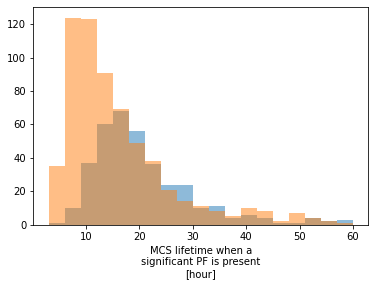

In [17]:
bins = np.arange(3,60.1,3)
ds_o_obs.isel(tracks=tid_o_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)
ds_o_obs.isel(tracks=tid_o_obs['ms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)

(array([0., 0., 0., 2., 1., 4., 1., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0.]),
 array([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39.,
        42., 45., 48., 51., 54., 57., 60.]),
 <BarContainer object of 19 artists>)

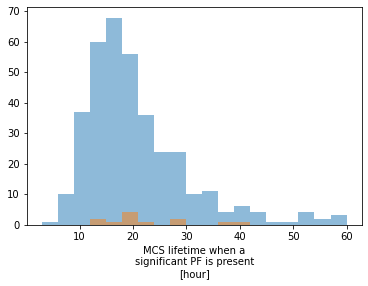

In [18]:
bins = np.arange(3,60.1,3)
ds_o_obs.isel(tracks=tid_o_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)
ds_o_m1.isel(tracks=tid_o_m1['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)

## Subset merge/split tracks

In [19]:
ds_nms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['nms'])
ds_nms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['nms'])
ds_ms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['ms'])
ds_ms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['ms'])

In [20]:
ds_nms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['nms'])
ds_nms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['nms'])
ds_ms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['ms'])
ds_ms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['ms'])

In [21]:
ds_nms_o_m2 = ds_o_m2.isel(tracks=tid_o_m2['nms'])
ds_nms_l_m2 = ds_l_m2.isel(tracks=tid_l_m2['nms'])
ds_ms_o_m2 = ds_o_m2.isel(tracks=tid_o_m2['ms'])
ds_ms_l_m2 = ds_l_m2.isel(tracks=tid_l_m2['ms'])

In [22]:
ds_nms_o_m3 = ds_o_m3.isel(tracks=tid_o_m3['nms'])
ds_nms_l_m3 = ds_l_m3.isel(tracks=tid_l_m3['nms'])
ds_ms_o_m3 = ds_o_m3.isel(tracks=tid_o_m3['ms'])
ds_ms_l_m3 = ds_l_m3.isel(tracks=tid_l_m3['ms'])

In [23]:
ds_nms_o_m4 = ds_o_m4.isel(tracks=tid_o_m4['nms'])
ds_nms_l_m4 = ds_l_m4.isel(tracks=tid_l_m4['nms'])
ds_ms_o_m4 = ds_o_m4.isel(tracks=tid_o_m4['ms'])
ds_ms_l_m4 = ds_l_m4.isel(tracks=tid_l_m4['ms'])

In [24]:
ds_nms_o_m5 = ds_o_m5.isel(tracks=tid_o_m5['nms'])
ds_nms_l_m5 = ds_l_m5.isel(tracks=tid_l_m5['nms'])
ds_ms_o_m5 = ds_o_m5.isel(tracks=tid_o_m5['ms'])
ds_ms_l_m5 = ds_l_m5.isel(tracks=tid_l_m5['ms'])

In [25]:
ds_nms_o_m6 = ds_o_m6.isel(tracks=tid_o_m6['nms'])
ds_nms_l_m6 = ds_l_m6.isel(tracks=tid_l_m6['nms'])
ds_ms_o_m6 = ds_o_m6.isel(tracks=tid_o_m6['ms'])
ds_ms_l_m6 = ds_l_m6.isel(tracks=tid_l_m6['ms'])

In [26]:
# ccslifetime_o_obs = ds_o_obs.track_duration * time_res_obs
# lifetime_o_obs = ds_o_obs.pf_lifetime
# # Add mergers/splits to get total CCS area
# ccsarea_o_obs = ds_o_obs.ccs_area + ds_o_obs.merge_ccs_area.sum(dim='mergers') + ds_o_obs.split_ccs_area.sum(dim='mergers')
# ccsdiam_o_obs = 2 * np.sqrt(ccsarea_o_obs / np.pi)
# mintb_o_obs = ds_o_obs.corecold_mintb
# mcsstatus_o_obs = ds_o_obs.mcs_status
# # startstatus_o_obs = ds_o_obs.start_status
# # endstatus_o_obs = ds_o_obs.end_status
# start_split_cn_o_obs = ds_o_obs.start_split_cloudnumber
# end_merge_cn_o_obs = ds_o_obs.end_merge_cloudnumber

# # All PF area (sum over nmaxpf dimension)
# pfarea_o_obs = ds_o_obs.pf_area.sum(dim='nmaxpf')
# # Largest PF area
# pfarea_largest_o_obs = ds_o_obs.pf_area.isel(nmaxpf=0)
# pfdiam_o_obs = 2 * np.sqrt(pfarea_largest_o_obs / np.pi)
# # Lifetime maximum
# maxpfdiam_o_obs = pfdiam_o_obs.max(dim='times')

# pfrainrate_o_obs = ds_o_obs.pf_rainrate.isel(nmaxpf=0)
# pfaccumrain_o_obs = ds_o_obs.pf_accumrain.sum(dim='nmaxpf')
# maxpfrainrate_o_obs = pfrainrate_o_obs.max(dim='times')
# meanpfrainrate_o_obs = pfrainrate_o_obs.mean(dim='times')

# # Compute volume rainrate [unit: kg/h]
# pfvolrain_o_obs = (ds_o_obs.total_rain * pixel_radius_obs**2)
# pfvolrainheavy_o_obs = (ds_o_obs.total_heavyrain * pixel_radius_obs**2)

## Function to compute 1D KDE

In [27]:
def get_kde1d(data, bins, kde_bw, kde_kernel='gaussian'):
    """
    Compute 1D KDE using Ski-learn
    
    Args:
        data: np.array
            Array containing data.
        bins: np.array
            Desired bins for plotting.
        kde_bw: float
            The bandwidth of the kernel.
        kde_kernel: string
            The kernel to use.
            
    Return:
        kde_out: np.array
            KDE at the desired bins.
    """
    # Flatten array to 1D
    data1d = data.flatten()
    # Remove NaN (sklearn KDE does not handle NaN), and make a new axis
    _data = data1d[~np.isnan(data1d)][:, np.newaxis]
    _bins = bins[:, np.newaxis]
    
    # Estimate 1D KDE following sklearn example
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    kde = KernelDensity(kernel=kde_kernel, bandwidth=kde_bw).fit(_data)
    # Get KDE values based on input bins
    log_dens = kde.score_samples(_bins)
    # Get linear density
    kde_out = np.exp(log_dens)
    return kde_out

#### CCS lifetime

In [28]:
lifetime_bins = np.linspace(0, 60, 1000)
# Ocean
kde_ccslifetime_nms_o_obs = get_kde1d((ds_nms_o_obs.track_duration * time_res_obs).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m1 = get_kde1d((ds_nms_o_m1.track_duration * time_res_m1).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m2 = get_kde1d((ds_nms_o_m2.track_duration * time_res_m2).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m3 = get_kde1d((ds_nms_o_m3.track_duration * time_res_m3).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m4 = get_kde1d((ds_nms_o_m4.track_duration * time_res_m4).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m5 = get_kde1d((ds_nms_o_m5.track_duration * time_res_m5).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m6 = get_kde1d((ds_nms_o_m6.track_duration * time_res_m6).data, lifetime_bins, kde_bw=3)
# Land
kde_ccslifetime_nms_l_obs = get_kde1d((ds_nms_l_obs.track_duration * time_res_obs).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m1 = get_kde1d((ds_nms_l_m1.track_duration * time_res_m1).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m2 = get_kde1d((ds_nms_l_m2.track_duration * time_res_m2).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m3 = get_kde1d((ds_nms_l_m3.track_duration * time_res_m3).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m4 = get_kde1d((ds_nms_l_m4.track_duration * time_res_m4).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m5 = get_kde1d((ds_nms_l_m5.track_duration * time_res_m5).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m6 = get_kde1d((ds_nms_l_m6.track_duration * time_res_m6).data, lifetime_bins, kde_bw=3)

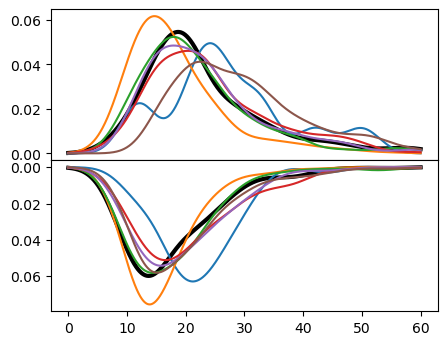

In [29]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_obs, 'k', lw=3)
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m1)
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m2)
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m3)
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m4)
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m5)
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m6)

ax = axes[1]
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_obs, 'k', lw=3)
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m1)
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m2)
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m3)
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m4)
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m5)
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### PF lifetime

In [30]:
# Merge or split tracks
kde_lifetime_ms_o_obs = get_kde1d(ds_ms_o_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_ms_o_m1 = get_kde1d(ds_ms_o_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)

# Non-merge & non-split tracks
# Ocean
kde_lifetime_nms_o_obs = get_kde1d(ds_nms_o_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_o_m1 = get_kde1d(ds_nms_o_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_o_m2 = get_kde1d(ds_nms_o_m2.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_o_m3 = get_kde1d(ds_nms_o_m3.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_o_m4 = get_kde1d(ds_nms_o_m4.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_o_m5 = get_kde1d(ds_nms_o_m5.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_o_m6 = get_kde1d(ds_nms_o_m6.pf_lifetime.data, lifetime_bins, kde_bw=3)
# Land
kde_lifetime_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_l_m2 = get_kde1d(ds_nms_l_m2.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_l_m3 = get_kde1d(ds_nms_l_m3.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_l_m4 = get_kde1d(ds_nms_l_m4.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_l_m5 = get_kde1d(ds_nms_l_m5.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_lifetime_nms_l_m6 = get_kde1d(ds_nms_l_m6.pf_lifetime.data, lifetime_bins, kde_bw=3)

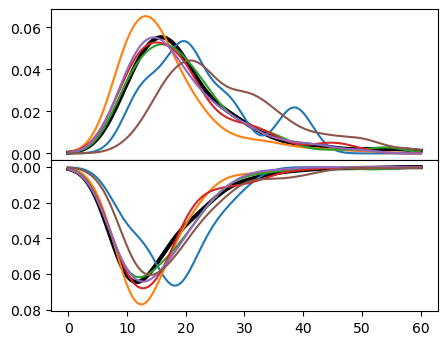

In [31]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_lifetime_nms_o_obs, 'k', lw=3)
ax.plot(lifetime_bins, kde_lifetime_nms_o_m1)
ax.plot(lifetime_bins, kde_lifetime_nms_o_m2)
ax.plot(lifetime_bins, kde_lifetime_nms_o_m3)
ax.plot(lifetime_bins, kde_lifetime_nms_o_m4)
ax.plot(lifetime_bins, kde_lifetime_nms_o_m5)
ax.plot(lifetime_bins, kde_lifetime_nms_o_m6)
ax = axes[1]
ax.plot(lifetime_bins, kde_lifetime_nms_l_obs, 'k', lw=3)
ax.plot(lifetime_bins, kde_lifetime_nms_l_m1)
ax.plot(lifetime_bins, kde_lifetime_nms_l_m2)
ax.plot(lifetime_bins, kde_lifetime_nms_l_m3)
ax.plot(lifetime_bins, kde_lifetime_nms_l_m4)
ax.plot(lifetime_bins, kde_lifetime_nms_l_m5)
ax.plot(lifetime_bins, kde_lifetime_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Max CCS area

In [32]:
# ccsarea_bins = np.linspace(3.5, 6.5, 1000)
ccsarea_bins = np.linspace(4, 6.8, 1000)
# Add mergers/splits to get total CCS area
# Ocean
ccsarea_o_obs = ds_nms_o_obs.ccs_area + ds_nms_o_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_o_obs.split_ccs_area.sum(dim='mergers')
maxccsarea_o_obs = ccsarea_o_obs.max(dim='times')
ccsarea_o_m1 = ds_nms_o_m1.ccs_area + ds_nms_o_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m1.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m1 = ccsarea_o_m1.max(dim='times')
ccsarea_o_m2 = ds_nms_o_m2.ccs_area + ds_nms_o_m2.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m2.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m2 = ccsarea_o_m2.max(dim='times')
ccsarea_o_m3 = ds_nms_o_m3.ccs_area + ds_nms_o_m3.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m3.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m3 = ccsarea_o_m3.max(dim='times')
ccsarea_o_m4 = ds_nms_o_m4.ccs_area + ds_nms_o_m4.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m4.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m4 = ccsarea_o_m4.max(dim='times')
ccsarea_o_m5 = ds_nms_o_m5.ccs_area + ds_nms_o_m5.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m5.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m5 = ccsarea_o_m5.max(dim='times')
ccsarea_o_m6 = ds_nms_o_m6.ccs_area + ds_nms_o_m6.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m6.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m6 = ccsarea_o_m6.max(dim='times')
# Land
ccsarea_l_obs = ds_nms_l_obs.ccs_area + ds_nms_l_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_l_obs.split_ccs_area.sum(dim='mergers')
maxccsarea_l_obs = ccsarea_l_obs.max(dim='times')
ccsarea_l_m1 = ds_nms_l_m1.ccs_area + ds_nms_l_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m1.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m1 = ccsarea_l_m1.max(dim='times')
ccsarea_l_m2 = ds_nms_l_m2.ccs_area + ds_nms_l_m2.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m2.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m2 = ccsarea_l_m2.max(dim='times')
ccsarea_l_m3 = ds_nms_l_m3.ccs_area + ds_nms_l_m3.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m3.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m3 = ccsarea_l_m3.max(dim='times')
ccsarea_l_m4 = ds_nms_l_m4.ccs_area + ds_nms_l_m4.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m4.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m4 = ccsarea_l_m4.max(dim='times')
ccsarea_l_m5 = ds_nms_l_m5.ccs_area + ds_nms_l_m5.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m5.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m5 = ccsarea_l_m5.max(dim='times')
ccsarea_l_m6 = ds_nms_l_m6.ccs_area + ds_nms_l_m6.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m6.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m6 = ccsarea_l_m6.max(dim='times')

# Ocean
kde_maxccsarea_nms_o_obs = get_kde1d(np.log10(maxccsarea_o_obs.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m1 = get_kde1d(np.log10(maxccsarea_o_m1.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m2 = get_kde1d(np.log10(maxccsarea_o_m2.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m3 = get_kde1d(np.log10(maxccsarea_o_m3.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m4 = get_kde1d(np.log10(maxccsarea_o_m4.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m5 = get_kde1d(np.log10(maxccsarea_o_m5.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m6 = get_kde1d(np.log10(maxccsarea_o_m6.data), ccsarea_bins, kde_bw=0.2)
# Land
kde_maxccsarea_nms_l_obs = get_kde1d(np.log10(maxccsarea_l_obs.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m1 = get_kde1d(np.log10(maxccsarea_l_m1.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m2 = get_kde1d(np.log10(maxccsarea_l_m2.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m3 = get_kde1d(np.log10(maxccsarea_l_m3.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m4 = get_kde1d(np.log10(maxccsarea_l_m4.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m5 = get_kde1d(np.log10(maxccsarea_l_m5.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m6 = get_kde1d(np.log10(maxccsarea_l_m6.data), ccsarea_bins, kde_bw=0.2)

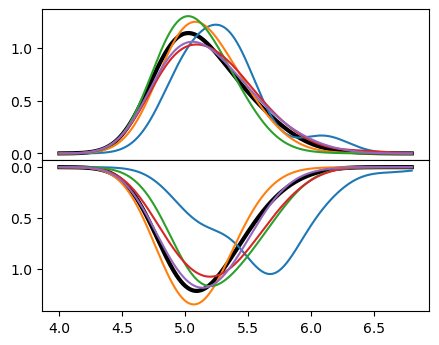

In [33]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_obs, 'k', lw=3)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_m1)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_m2)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_m3)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_m4)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_m5)

ax = axes[1]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_obs, 'k', lw=3)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m1)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m2)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m3)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m4)
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m5)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Max cold core area

In [34]:
corearea_bins = np.linspace(3, 6, 1000)
# Ocean
kde_maxcorearea_nms_o_obs = get_kde1d(np.log10(ds_nms_o_obs.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_o_m1 = get_kde1d(np.log10(ds_nms_o_m1.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_o_m2 = get_kde1d(np.log10(ds_nms_o_m2.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_o_m3 = get_kde1d(np.log10(ds_nms_o_m3.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_o_m4 = get_kde1d(np.log10(ds_nms_o_m4.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_o_m5 = get_kde1d(np.log10(ds_nms_o_m5.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_o_m6 = get_kde1d(np.log10(ds_nms_o_m6.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
# Land
kde_maxcorearea_nms_l_obs = get_kde1d(np.log10(ds_nms_l_obs.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_l_m1 = get_kde1d(np.log10(ds_nms_l_m1.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_l_m2 = get_kde1d(np.log10(ds_nms_l_m2.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_l_m3 = get_kde1d(np.log10(ds_nms_l_m3.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_l_m4 = get_kde1d(np.log10(ds_nms_l_m4.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_l_m5 = get_kde1d(np.log10(ds_nms_l_m5.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)
kde_maxcorearea_nms_l_m6 = get_kde1d(np.log10(ds_nms_l_m6.core_area.max(dim='times').data), corearea_bins, kde_bw=0.2)

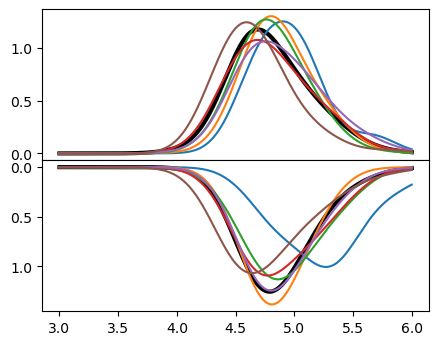

In [35]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(corearea_bins, kde_maxcorearea_nms_o_obs, 'k', lw=3)
ax.plot(corearea_bins, kde_maxcorearea_nms_o_m1)
ax.plot(corearea_bins, kde_maxcorearea_nms_o_m2)
ax.plot(corearea_bins, kde_maxcorearea_nms_o_m3)
ax.plot(corearea_bins, kde_maxcorearea_nms_o_m4)
ax.plot(corearea_bins, kde_maxcorearea_nms_o_m5)
ax.plot(corearea_bins, kde_maxcorearea_nms_o_m6)

ax = axes[1]
ax.plot(corearea_bins, kde_maxcorearea_nms_l_obs, 'k', lw=3)
ax.plot(corearea_bins, kde_maxcorearea_nms_l_m1)
ax.plot(corearea_bins, kde_maxcorearea_nms_l_m2)
ax.plot(corearea_bins, kde_maxcorearea_nms_l_m3)
ax.plot(corearea_bins, kde_maxcorearea_nms_l_m4)
ax.plot(corearea_bins, kde_maxcorearea_nms_l_m5)
ax.plot(corearea_bins, kde_maxcorearea_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Max PF area

In [36]:
pfarea_bins = np.linspace(3.3, 6, 1000)
# Sum all PFs at a given time, then take max during lifetime
# Ocean
maxpfarea_o_obs = ds_nms_o_obs.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m1 = ds_nms_o_m1.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m2 = ds_nms_o_m2.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m3 = ds_nms_o_m3.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m4 = ds_nms_o_m4.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m5 = ds_nms_o_m5.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m6 = ds_nms_o_m6.pf_area.sum(dim='nmaxpf').max(dim='times')
# Land
maxpfarea_l_obs = ds_nms_l_obs.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m1 = ds_nms_l_m1.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m2 = ds_nms_l_m2.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m3 = ds_nms_l_m3.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m4 = ds_nms_l_m4.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m5 = ds_nms_l_m5.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m6 = ds_nms_l_m6.pf_area.sum(dim='nmaxpf').max(dim='times')

# Ocean
kde_maxpfarea_nms_o_obs = get_kde1d(np.log10(maxpfarea_o_obs.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m1 = get_kde1d(np.log10(maxpfarea_o_m1.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m2 = get_kde1d(np.log10(maxpfarea_o_m2.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m3 = get_kde1d(np.log10(maxpfarea_o_m3.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m4 = get_kde1d(np.log10(maxpfarea_o_m4.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m5 = get_kde1d(np.log10(maxpfarea_o_m5.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m6 = get_kde1d(np.log10(maxpfarea_o_m6.data), pfarea_bins, kde_bw=0.2)
# Land
kde_maxpfarea_nms_l_obs = get_kde1d(np.log10(maxpfarea_l_obs.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m1 = get_kde1d(np.log10(maxpfarea_l_m1.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m2 = get_kde1d(np.log10(maxpfarea_l_m2.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m3 = get_kde1d(np.log10(maxpfarea_l_m3.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m4 = get_kde1d(np.log10(maxpfarea_l_m4.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m5 = get_kde1d(np.log10(maxpfarea_l_m5.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m6 = get_kde1d(np.log10(maxpfarea_l_m6.data), pfarea_bins, kde_bw=0.2)

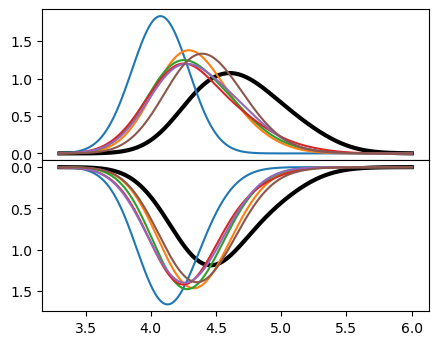

In [37]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_obs, 'k', lw=3)
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m1)
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m2)
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m3)
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m4)
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m5)
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m6)
ax = axes[1]
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_obs, 'k', lw=3)
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m1)
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m2)
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m3)
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m4)
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m5)
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Mean PF rain rate

In [38]:
pfrainrate_bins = np.linspace(2, 18, 1000)
# Ocean
kde_meanpfrainrate_nms_o_obs = get_kde1d(ds_nms_o_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m1 = get_kde1d(ds_nms_o_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m2 = get_kde1d(ds_nms_o_m2.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m3 = get_kde1d(ds_nms_o_m3.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m4 = get_kde1d(ds_nms_o_m4.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m5 = get_kde1d(ds_nms_o_m5.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m6 = get_kde1d(ds_nms_o_m6.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
# Land
kde_meanpfrainrate_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m2 = get_kde1d(ds_nms_l_m2.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m3 = get_kde1d(ds_nms_l_m3.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m4 = get_kde1d(ds_nms_l_m4.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m5 = get_kde1d(ds_nms_l_m5.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m6 = get_kde1d(ds_nms_l_m6.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)

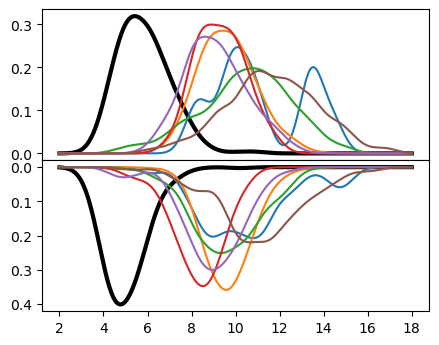

In [39]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_obs, 'k', lw=3)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m1)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m2)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m3)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m4)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m5)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m6)
ax = axes[1]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_obs, 'k', lw=3)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m1)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m2)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m3)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m4)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m5)
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

In [40]:
maxrainrate_bins = np.linspace(2, 90, 1000)
# Ocean
kde_meanmaxrainrate_nms_o_obs = get_kde1d(ds_nms_o_obs.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_o_m1 = get_kde1d(ds_nms_o_m1.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_o_m2 = get_kde1d(ds_nms_o_m2.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_o_m3 = get_kde1d(ds_nms_o_m3.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_o_m4 = get_kde1d(ds_nms_o_m4.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_o_m5 = get_kde1d(ds_nms_o_m5.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_o_m6 = get_kde1d(ds_nms_o_m6.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
# Land
kde_meanmaxrainrate_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_l_m2 = get_kde1d(ds_nms_l_m2.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_l_m3 = get_kde1d(ds_nms_l_m3.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_l_m4 = get_kde1d(ds_nms_l_m4.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_l_m5 = get_kde1d(ds_nms_l_m5.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)
kde_meanmaxrainrate_nms_l_m6 = get_kde1d(ds_nms_l_m6.pf_maxrainrate.isel(nmaxpf=0).mean(dim='times').data, maxrainrate_bins, kde_bw=2)

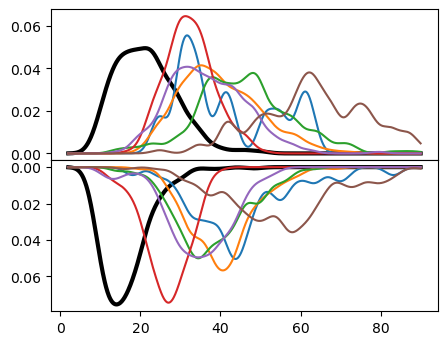

In [41]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_obs, 'k', lw=3)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_m1)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_m2)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_m3)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_m4)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_m5)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_o_m6)
ax = axes[1]
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_obs, 'k', lw=3)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_m1)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_m2)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_m3)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_m4)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_m5)
ax.plot(maxrainrate_bins, kde_meanmaxrainrate_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Lifetime-average min Tb

In [42]:
avgmintb_bins = np.linspace(180, 230, 1000)
# Ocean
kde_avgmintb_nms_o_obs = get_kde1d(ds_nms_o_obs.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m1 = get_kde1d(ds_nms_o_m1.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m2 = get_kde1d(ds_nms_o_m2.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m3 = get_kde1d(ds_nms_o_m3.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m4 = get_kde1d(ds_nms_o_m4.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m5 = get_kde1d(ds_nms_o_m5.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m6 = get_kde1d(ds_nms_o_m6.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
# Land
kde_avgmintb_nms_l_obs = get_kde1d(ds_nms_l_obs.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m1 = get_kde1d(ds_nms_l_m1.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m2 = get_kde1d(ds_nms_l_m2.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m3 = get_kde1d(ds_nms_l_m3.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m4 = get_kde1d(ds_nms_l_m4.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m5 = get_kde1d(ds_nms_l_m5.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m6 = get_kde1d(ds_nms_l_m6.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)

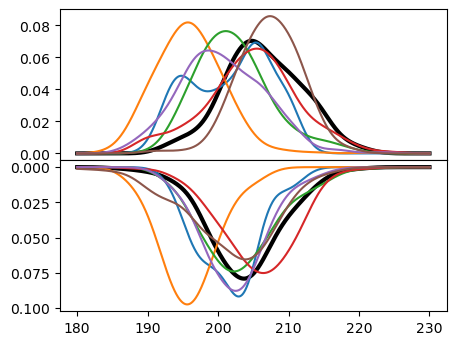

In [43]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_obs, 'k', lw=3)
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m1)
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m2)
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m3)
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m4)
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m5)
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m6)
ax = axes[1]
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_obs, 'k', lw=3)
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m1)
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m2)
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m3)
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m4)
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m5)
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Lifetime-min min Tb

In [44]:
mintb_bins = np.linspace(170, 220, 1000)
# Ocean
kde_mintb_nms_o_obs = get_kde1d(ds_nms_o_obs.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m1 = get_kde1d(ds_nms_o_m1.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m2 = get_kde1d(ds_nms_o_m2.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m3 = get_kde1d(ds_nms_o_m3.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m4 = get_kde1d(ds_nms_o_m4.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m5 = get_kde1d(ds_nms_o_m5.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m6 = get_kde1d(ds_nms_o_m6.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
# Land
kde_mintb_nms_l_obs = get_kde1d(ds_nms_l_obs.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m1 = get_kde1d(ds_nms_l_m1.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m2 = get_kde1d(ds_nms_l_m2.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m3 = get_kde1d(ds_nms_l_m3.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m4 = get_kde1d(ds_nms_l_m4.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m5 = get_kde1d(ds_nms_l_m5.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m6 = get_kde1d(ds_nms_l_m6.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)

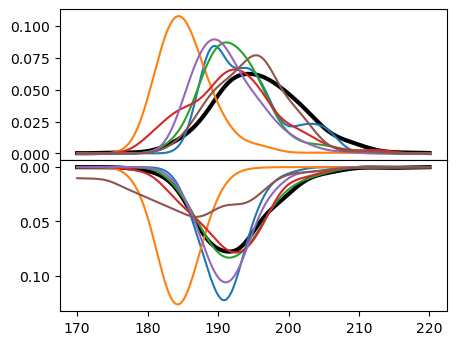

In [45]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(mintb_bins, kde_mintb_nms_o_obs, 'k', lw=3)
ax.plot(mintb_bins, kde_mintb_nms_o_m1)
ax.plot(mintb_bins, kde_mintb_nms_o_m2)
ax.plot(mintb_bins, kde_mintb_nms_o_m3)
ax.plot(mintb_bins, kde_mintb_nms_o_m4)
ax.plot(mintb_bins, kde_mintb_nms_o_m5)
ax.plot(mintb_bins, kde_mintb_nms_o_m6)
ax = axes[1]
ax.plot(mintb_bins, kde_mintb_nms_l_obs, 'k', lw=3)
ax.plot(mintb_bins, kde_mintb_nms_l_m1)
ax.plot(mintb_bins, kde_mintb_nms_l_m2)
ax.plot(mintb_bins, kde_mintb_nms_l_m3)
ax.plot(mintb_bins, kde_mintb_nms_l_m4)
ax.plot(mintb_bins, kde_mintb_nms_l_m5)
ax.plot(mintb_bins, kde_mintb_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Total rain volume

In [48]:
# Lifetime total rain volume [unit: kg]
# Ocean
pfvolrain_o_obs = ds_nms_o_obs.total_rain.sum(dim='times') * pixel_radius_obs**2
pfvolrain_o_m1 = ds_nms_o_m1.total_rain.sum(dim='times') * pixel_radius_m1**2
pfvolrain_o_m2 = ds_nms_o_m2.total_rain.sum(dim='times') * pixel_radius_m2**2
pfvolrain_o_m3 = ds_nms_o_m3.total_rain.sum(dim='times') * pixel_radius_m3**2
pfvolrain_o_m4 = ds_nms_o_m4.total_rain.sum(dim='times') * pixel_radius_m4**2
pfvolrain_o_m5 = ds_nms_o_m5.total_rain.sum(dim='times') * pixel_radius_m5**2
pfvolrain_o_m6 = ds_nms_o_m6.total_rain.sum(dim='times') * pixel_radius_m6**2
# Land
pfvolrain_l_obs = ds_nms_l_obs.total_rain.sum(dim='times') * pixel_radius_obs**2
pfvolrain_l_m1 = ds_nms_l_m1.total_rain.sum(dim='times') * pixel_radius_m1**2
pfvolrain_l_m2 = ds_nms_l_m2.total_rain.sum(dim='times') * pixel_radius_m2**2
pfvolrain_l_m3 = ds_nms_l_m3.total_rain.sum(dim='times') * pixel_radius_m3**2
pfvolrain_l_m4 = ds_nms_l_m4.total_rain.sum(dim='times') * pixel_radius_m4**2
pfvolrain_l_m5 = ds_nms_l_m5.total_rain.sum(dim='times') * pixel_radius_m5**2
pfvolrain_l_m6 = ds_nms_l_m6.total_rain.sum(dim='times') * pixel_radius_m6**2

volrain_bins = np.linspace(5, 8.5, 1000)
# Ocean
kde_pfvolrain_nms_o_obs = get_kde1d(np.log10(pfvolrain_o_obs.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m1 = get_kde1d(np.log10(pfvolrain_o_m1.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m2 = get_kde1d(np.log10(pfvolrain_o_m2.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m3 = get_kde1d(np.log10(pfvolrain_o_m3.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m4 = get_kde1d(np.log10(pfvolrain_o_m4.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m5 = get_kde1d(np.log10(pfvolrain_o_m5.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m6 = get_kde1d(np.log10(pfvolrain_o_m6.data), volrain_bins, kde_bw=0.2)
# Land
kde_pfvolrain_nms_l_obs = get_kde1d(np.log10(pfvolrain_l_obs.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m1 = get_kde1d(np.log10(pfvolrain_l_m1.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m2 = get_kde1d(np.log10(pfvolrain_l_m2.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m3 = get_kde1d(np.log10(pfvolrain_l_m3.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m4 = get_kde1d(np.log10(pfvolrain_l_m4.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m5 = get_kde1d(np.log10(pfvolrain_l_m5.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m6 = get_kde1d(np.log10(pfvolrain_l_m6.data), volrain_bins, kde_bw=0.2)

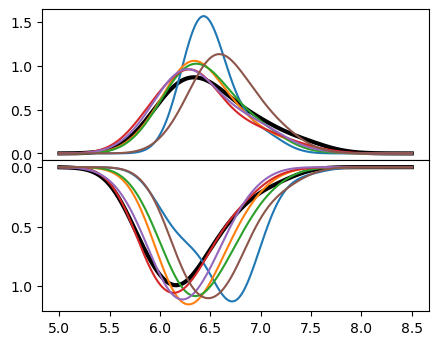

In [49]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(volrain_bins, kde_pfvolrain_nms_o_obs, 'k', lw=3)
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m1)
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m2)
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m3)
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m4)
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m5)
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m6)
ax = axes[1]
ax.plot(volrain_bins, kde_pfvolrain_nms_l_obs, 'k', lw=3)
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m1)
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m2)
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m3)
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m4)
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m5)
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Heavy rain volume

In [50]:
# Lifetime total heavy rain volume [unit: kg]
# Ocean
pfheavyvolrain_o_obs = ds_nms_o_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2
pfheavyvolrain_o_m1 = ds_nms_o_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2
pfheavyvolrain_o_m2 = ds_nms_o_m2.total_heavyrain.sum(dim='times') * pixel_radius_m2**2
pfheavyvolrain_o_m3 = ds_nms_o_m3.total_heavyrain.sum(dim='times') * pixel_radius_m3**2
pfheavyvolrain_o_m4 = ds_nms_o_m4.total_heavyrain.sum(dim='times') * pixel_radius_m4**2
pfheavyvolrain_o_m5 = ds_nms_o_m5.total_heavyrain.sum(dim='times') * pixel_radius_m5**2
pfheavyvolrain_o_m6 = ds_nms_o_m6.total_heavyrain.sum(dim='times') * pixel_radius_m6**2
# Land
pfheavyvolrain_l_obs = ds_nms_l_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2
pfheavyvolrain_l_m1 = ds_nms_l_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2
pfheavyvolrain_l_m2 = ds_nms_l_m2.total_heavyrain.sum(dim='times') * pixel_radius_m2**2
pfheavyvolrain_l_m3 = ds_nms_l_m3.total_heavyrain.sum(dim='times') * pixel_radius_m3**2
pfheavyvolrain_l_m4 = ds_nms_l_m4.total_heavyrain.sum(dim='times') * pixel_radius_m4**2
pfheavyvolrain_l_m5 = ds_nms_l_m5.total_heavyrain.sum(dim='times') * pixel_radius_m5**2
pfheavyvolrain_l_m6 = ds_nms_l_m6.total_heavyrain.sum(dim='times') * pixel_radius_m6**2

heavyvolrain_bins = np.linspace(4, 8, 1000)
# Ocean
kde_pfheavyvolrain_nms_o_obs = get_kde1d(np.log10(pfheavyvolrain_o_obs.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m1 = get_kde1d(np.log10(pfheavyvolrain_o_m1.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m2 = get_kde1d(np.log10(pfheavyvolrain_o_m2.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m3 = get_kde1d(np.log10(pfheavyvolrain_o_m3.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m4 = get_kde1d(np.log10(pfheavyvolrain_o_m4.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m5 = get_kde1d(np.log10(pfheavyvolrain_o_m5.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m6 = get_kde1d(np.log10(pfheavyvolrain_o_m6.data), heavyvolrain_bins, kde_bw=0.2)
# Land
kde_pfheavyvolrain_nms_l_obs = get_kde1d(np.log10(pfheavyvolrain_l_obs.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m1 = get_kde1d(np.log10(pfheavyvolrain_l_m1.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m2 = get_kde1d(np.log10(pfheavyvolrain_l_m2.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m3 = get_kde1d(np.log10(pfheavyvolrain_l_m3.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m4 = get_kde1d(np.log10(pfheavyvolrain_l_m4.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m5 = get_kde1d(np.log10(pfheavyvolrain_l_m5.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m6 = get_kde1d(np.log10(pfheavyvolrain_l_m6.data), heavyvolrain_bins, kde_bw=0.2)

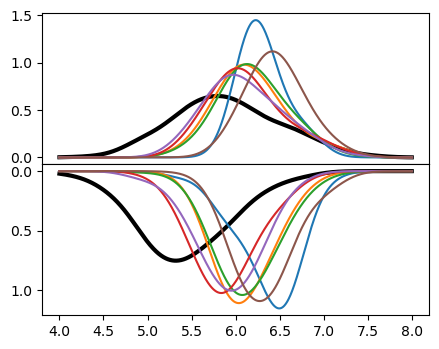

In [51]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_obs, 'k', lw=3)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m1)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m2)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m3)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m4)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m5)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m6)
ax = axes[1]
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_obs, 'k', lw=3)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m1)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m2)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m3)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m4)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m5)
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### Heavy rain ratio

In [52]:
# Heavy rain volume ratio (heavy rain vol. / total rain vol.)
# Ocean
pfhrr_nms_o_obs = 100 * pfheavyvolrain_o_obs / pfvolrain_o_obs
pfhrr_nms_o_m1 = 100 * pfheavyvolrain_o_m1 / pfvolrain_o_m1
pfhrr_nms_o_m2 = 100 * pfheavyvolrain_o_m2 / pfvolrain_o_m2
pfhrr_nms_o_m3 = 100 * pfheavyvolrain_o_m3 / pfvolrain_o_m3
pfhrr_nms_o_m4 = 100 * pfheavyvolrain_o_m4 / pfvolrain_o_m4
pfhrr_nms_o_m5 = 100 * pfheavyvolrain_o_m5 / pfvolrain_o_m5
pfhrr_nms_o_m6 = 100 * pfheavyvolrain_o_m6 / pfvolrain_o_m6
# Land
pfhrr_nms_l_obs = 100 * pfheavyvolrain_l_obs / pfvolrain_l_obs
pfhrr_nms_l_m1 = 100 * pfheavyvolrain_l_m1 / pfvolrain_l_m1
pfhrr_nms_l_m2 = 100 * pfheavyvolrain_l_m2 / pfvolrain_l_m2
pfhrr_nms_l_m3 = 100 * pfheavyvolrain_l_m3 / pfvolrain_l_m3
pfhrr_nms_l_m4 = 100 * pfheavyvolrain_l_m4 / pfvolrain_l_m4
pfhrr_nms_l_m5 = 100 * pfheavyvolrain_l_m5 / pfvolrain_l_m5
pfhrr_nms_l_m6 = 100 * pfheavyvolrain_l_m6 / pfvolrain_l_m6

pfhrr_bins = np.linspace(0, 100, 1000)
# Ocean
kde_pfhrr_nms_o_obs = get_kde1d(pfhrr_nms_o_obs.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m1 = get_kde1d(pfhrr_nms_o_m1.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m2 = get_kde1d(pfhrr_nms_o_m2.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m3 = get_kde1d(pfhrr_nms_o_m3.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m4 = get_kde1d(pfhrr_nms_o_m4.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m5 = get_kde1d(pfhrr_nms_o_m5.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m6 = get_kde1d(pfhrr_nms_o_m6.data, pfhrr_bins, kde_bw=4)
# Land
kde_pfhrr_nms_l_obs = get_kde1d(pfhrr_nms_l_obs.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m1 = get_kde1d(pfhrr_nms_l_m1.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m2 = get_kde1d(pfhrr_nms_l_m2.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m3 = get_kde1d(pfhrr_nms_l_m3.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m4 = get_kde1d(pfhrr_nms_l_m4.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m5 = get_kde1d(pfhrr_nms_l_m5.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m6 = get_kde1d(pfhrr_nms_l_m6.data, pfhrr_bins, kde_bw=4)

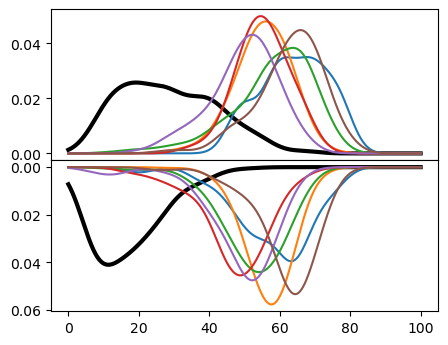

In [53]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_obs, 'k', lw=3)
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m1)
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m2)
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m3)
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m4)
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m5)
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m6)
ax = axes[1]
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_obs, 'k', lw=3)
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m1)
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m2)
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m3)
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m4)
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m5)
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

#### MCS PF speed

In [54]:
# PF movement speed
pfspeed_bins = np.linspace(0, 17, 1000)
# Ocean
kde_pfspeed_nms_o_obs = get_kde1d(ds_nms_o_obs.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m1 = get_kde1d(ds_nms_o_m1.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m2 = get_kde1d(ds_nms_o_m2.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m3 = get_kde1d(ds_nms_o_m3.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m4 = get_kde1d(ds_nms_o_m4.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m5 = get_kde1d(ds_nms_o_m5.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m6 = get_kde1d(ds_nms_o_m6.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
# Land
kde_pfspeed_nms_l_obs = get_kde1d(ds_nms_l_obs.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m1 = get_kde1d(ds_nms_l_m1.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m2 = get_kde1d(ds_nms_l_m2.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m3 = get_kde1d(ds_nms_l_m3.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m4 = get_kde1d(ds_nms_l_m4.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m5 = get_kde1d(ds_nms_l_m5.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m6 = get_kde1d(ds_nms_l_m6.movement_speed.mean(dim='times').data, pfspeed_bins, kde_bw=2)

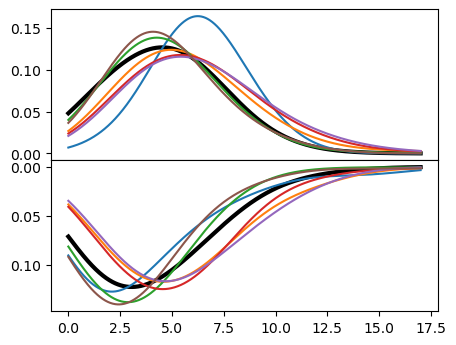

In [55]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_obs, 'k', lw=3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m1)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m2)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m4)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m5)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m6)
ax = axes[1]
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_obs, 'k', lw=3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m1)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m2)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m4)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m5)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

In [56]:
# Ocean
kde_pfspeed_nms_o_obs = get_kde1d(ds_nms_o_obs.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m1 = get_kde1d(ds_nms_o_m1.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m2 = get_kde1d(ds_nms_o_m2.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m3 = get_kde1d(ds_nms_o_m3.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m4 = get_kde1d(ds_nms_o_m4.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m5 = get_kde1d(ds_nms_o_m5.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m6 = get_kde1d(ds_nms_o_m6.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
# Land
kde_pfspeed_nms_l_obs = get_kde1d(ds_nms_l_obs.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m1 = get_kde1d(ds_nms_l_m1.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m2 = get_kde1d(ds_nms_l_m2.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m3 = get_kde1d(ds_nms_l_m3.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m4 = get_kde1d(ds_nms_l_m4.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m5 = get_kde1d(ds_nms_l_m5.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m6 = get_kde1d(ds_nms_l_m6.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)

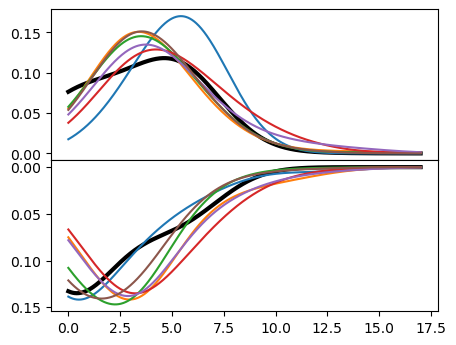

In [57]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_obs, 'k', lw=3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m1)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m2)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m4)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m5)
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m6)
ax = axes[1]
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_obs, 'k', lw=3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m1)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m2)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m3)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m4)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m5)
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m6)
ax.invert_yaxis()
fig.subplots_adjust(hspace=0)

## Put variables into dictionary for plotting

In [58]:
# Ocean variables
ccslifetime_o_dict = {
    'obs':kde_ccslifetime_nms_o_obs,
    'm1': kde_ccslifetime_nms_o_m1,
    'm2': kde_ccslifetime_nms_o_m2,
    'm3': kde_ccslifetime_nms_o_m3,
    'm4': kde_ccslifetime_nms_o_m4,
    'm5': kde_ccslifetime_nms_o_m5,
    'm6': kde_ccslifetime_nms_o_m6,
}
pfspeed_o_dict = {
    'obs': kde_pfspeed_nms_o_obs,
    'm1': kde_pfspeed_nms_o_m1,
    'm2': kde_pfspeed_nms_o_m2,
    'm3': kde_pfspeed_nms_o_m3,
    'm4': kde_pfspeed_nms_o_m4,
    'm5': kde_pfspeed_nms_o_m5,
    'm6': kde_pfspeed_nms_o_m6,
}
ccsarea_o_dict = {
    'obs': kde_maxccsarea_nms_o_obs,
    'm1': kde_maxccsarea_nms_o_m1,
    'm2': kde_maxccsarea_nms_o_m2,
    'm3': kde_maxccsarea_nms_o_m3,
    'm4': kde_maxccsarea_nms_o_m4,
    'm5': kde_maxccsarea_nms_o_m5,
    'm6': kde_maxccsarea_nms_o_m6,
}
mintb_o_dict = {
    'obs': kde_avgmintb_nms_o_obs,
    'm1': kde_avgmintb_nms_o_m1,
    'm2': kde_avgmintb_nms_o_m2,
    'm3': kde_avgmintb_nms_o_m3,
    'm4': kde_avgmintb_nms_o_m4,
    'm5': kde_avgmintb_nms_o_m5,
    'm6': kde_avgmintb_nms_o_m6,
}
pfarea_o_dict = {
    'obs': kde_maxpfarea_nms_o_obs,
    'm1': kde_maxpfarea_nms_o_m1,
    'm2': kde_maxpfarea_nms_o_m2,
    'm3': kde_maxpfarea_nms_o_m3,
    'm4': kde_maxpfarea_nms_o_m4,
    'm5': kde_maxpfarea_nms_o_m5,
    'm6': kde_maxpfarea_nms_o_m6,
}
pfrainrate_o_dict = {
    'obs': kde_meanpfrainrate_nms_o_obs,
    'm1': kde_meanpfrainrate_nms_o_m1,
    'm2': kde_meanpfrainrate_nms_o_m2,
    'm3': kde_meanpfrainrate_nms_o_m3,
    'm4': kde_meanpfrainrate_nms_o_m4,
    'm5': kde_meanpfrainrate_nms_o_m5,
    'm6': kde_meanpfrainrate_nms_o_m6,
}
volrain_o_dict = {
    'obs': kde_pfvolrain_nms_o_obs,
    'm1': kde_pfvolrain_nms_o_m1,
    'm2': kde_pfvolrain_nms_o_m2,
    'm3': kde_pfvolrain_nms_o_m3,
    'm4': kde_pfvolrain_nms_o_m4,
    'm5': kde_pfvolrain_nms_o_m5,
    'm6': kde_pfvolrain_nms_o_m6,
}
heavyvolrain_o_dict = {
    'obs': kde_pfheavyvolrain_nms_o_obs,
    'm1': kde_pfheavyvolrain_nms_o_m1,
    'm2': kde_pfheavyvolrain_nms_o_m2,
    'm3': kde_pfheavyvolrain_nms_o_m3,
    'm4': kde_pfheavyvolrain_nms_o_m4,
    'm5': kde_pfheavyvolrain_nms_o_m5,
    'm6': kde_pfheavyvolrain_nms_o_m6,
}
hrr_o_dict = {
    'obs': kde_pfhrr_nms_o_obs,
    'm1': kde_pfhrr_nms_o_m1,
    'm2': kde_pfhrr_nms_o_m2,
    'm3': kde_pfhrr_nms_o_m3,
    'm4': kde_pfhrr_nms_o_m4,
    'm5': kde_pfhrr_nms_o_m5,
    'm6': kde_pfhrr_nms_o_m6,
}

# Land variables
ccslifetime_l_dict = {
    'obs':kde_ccslifetime_nms_l_obs,
    'm1': kde_ccslifetime_nms_l_m1,
    'm2': kde_ccslifetime_nms_l_m2,
    'm3': kde_ccslifetime_nms_l_m3,
    'm4': kde_ccslifetime_nms_l_m4,
    'm5': kde_ccslifetime_nms_l_m5,
    'm6': kde_ccslifetime_nms_l_m6,
}
pfspeed_l_dict = {
    'obs': kde_pfspeed_nms_l_obs,
    'm1': kde_pfspeed_nms_l_m1,
    'm2': kde_pfspeed_nms_l_m2,
    'm3': kde_pfspeed_nms_l_m3,
    'm4': kde_pfspeed_nms_l_m4,
    'm5': kde_pfspeed_nms_l_m5,
    'm6': kde_pfspeed_nms_l_m6,
}
ccsarea_l_dict = {
    'obs': kde_maxccsarea_nms_l_obs,
    'm1': kde_maxccsarea_nms_l_m1,
    'm2': kde_maxccsarea_nms_l_m2,
    'm3': kde_maxccsarea_nms_l_m3,
    'm4': kde_maxccsarea_nms_l_m4,
    'm5': kde_maxccsarea_nms_l_m5,
    'm6': kde_maxccsarea_nms_l_m6,
}
mintb_l_dict = {
    'obs': kde_avgmintb_nms_l_obs,
    'm1': kde_avgmintb_nms_l_m1,
    'm2': kde_avgmintb_nms_l_m2,
    'm3': kde_avgmintb_nms_l_m3,
    'm4': kde_avgmintb_nms_l_m4,
    'm5': kde_avgmintb_nms_l_m5,
    'm6': kde_avgmintb_nms_l_m6,
}
pfarea_l_dict = {
    'obs': kde_maxpfarea_nms_l_obs,
    'm1': kde_maxpfarea_nms_l_m1,
    'm2': kde_maxpfarea_nms_l_m2,
    'm3': kde_maxpfarea_nms_l_m3,
    'm4': kde_maxpfarea_nms_l_m4,
    'm5': kde_maxpfarea_nms_l_m5,
    'm6': kde_maxpfarea_nms_l_m6,
}
pfrainrate_l_dict = {
    'obs': kde_meanpfrainrate_nms_l_obs,
    'm1': kde_meanpfrainrate_nms_l_m1,
    'm2': kde_meanpfrainrate_nms_l_m2,
    'm3': kde_meanpfrainrate_nms_l_m3,
    'm4': kde_meanpfrainrate_nms_l_m4,
    'm5': kde_meanpfrainrate_nms_l_m5,
    'm6': kde_meanpfrainrate_nms_l_m6,
}
volrain_l_dict = {
    'obs': kde_pfvolrain_nms_l_obs,
    'm1': kde_pfvolrain_nms_l_m1,
    'm2': kde_pfvolrain_nms_l_m2,
    'm3': kde_pfvolrain_nms_l_m3,
    'm4': kde_pfvolrain_nms_l_m4,
    'm5': kde_pfvolrain_nms_l_m5,
    'm6': kde_pfvolrain_nms_l_m6,
}
heavyvolrain_l_dict = {
    'obs': kde_pfheavyvolrain_nms_l_obs,
    'm1': kde_pfheavyvolrain_nms_l_m1,
    'm2': kde_pfheavyvolrain_nms_l_m2,
    'm3': kde_pfheavyvolrain_nms_l_m3,
    'm4': kde_pfheavyvolrain_nms_l_m4,
    'm5': kde_pfheavyvolrain_nms_l_m5,
    'm6': kde_pfheavyvolrain_nms_l_m6,
}
hrr_l_dict = {
    'obs': kde_pfhrr_nms_l_obs,
    'm1': kde_pfhrr_nms_l_m1,
    'm2': kde_pfhrr_nms_l_m2,
    'm3': kde_pfhrr_nms_l_m3,
    'm4': kde_pfhrr_nms_l_m4,
    'm5': kde_pfhrr_nms_l_m5,
    'm6': kde_pfhrr_nms_l_m6,
}

## Function to plot mirror 1D KDE on (m x n) panels

In [59]:
def plot_pdf_mirror_mxn(nrow, ncol, bins, data_top, data_bot, titles, xlabels, legends, figname,  
                        map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                        legend_fontsize=11, legend_loc='best', label_topbot=None, figsize=[10,10]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.15, hspace=0.3)
    # Use GridSpecFromSubplotSpec to setup top and bottom mirror panels
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.18, hspace=0)
    gs_bot = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.18, hspace=0)

    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }
    
    # Top row
    row = 0
    for col in range(0, ncol):
        # Top panel
        ax1 = plt.subplot(gs_top[0,col])
        ax1.plot(bins[row][col], data_top[row][col]['obs'], lcolors['obs'], lw=lw*3, label=legends['obs'])
        ax1.plot(bins[row][col], data_top[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
        ax1.plot(bins[row][col], data_top[row][col]['m2'], lcolors['m2'], lw=lw, label=legends['m2'])
        ax1.plot(bins[row][col], data_top[row][col]['m3'], lcolors['m3'], lw=lw, label=legends['m3'])
        ax1.plot(bins[row][col], data_top[row][col]['m4'], lcolors['m4'], lw=lw, label=legends['m4'])
        ax1.plot(bins[row][col], data_top[row][col]['m5'], lcolors['m5'], lw=lw, label=legends['m5'])
        ax1.plot(bins[row][col], data_top[row][col]['m6'], lcolors['m6'], lw=lw, label=legends['m6'])
        # Bottom mirror panel
        ax2 = plt.subplot(gs_top[1,col], sharex=ax1)
        ax2.invert_yaxis()
        ax2.plot(bins[row][col], data_bot[row][col]['obs'], lcolors['obs'], lw=lw*3, label=legends['obs'])
        ax2.plot(bins[row][col], data_bot[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
        ax2.plot(bins[row][col], data_bot[row][col]['m2'], lcolors['m2'], lw=lw, label=legends['m2'])
        ax2.plot(bins[row][col], data_bot[row][col]['m3'], lcolors['m3'], lw=lw, label=legends['m3'])
        ax2.plot(bins[row][col], data_bot[row][col]['m4'], lcolors['m4'], lw=lw, label=legends['m4'])
        ax2.plot(bins[row][col], data_bot[row][col]['m5'], lcolors['m5'], lw=lw, label=legends['m5'])
        ax2.plot(bins[row][col], data_bot[row][col]['m6'], lcolors['m6'], lw=lw, label=legends['m6'])
        # Labels, gridlines, etc.
        ax1.grid(which='major', ls='--')
        ax2.grid(which='major', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        # Label Ocean/Land
        ax1.text(0.02, 0.9, label_topbot[0], ha='left', transform=ax1.transAxes)
        ax2.text(0.02, 0.1, label_topbot[1], ha='left', transform=ax2.transAxes)
        # Label yaxis, legend
        if (col == 0):
            ax2.text(-0.2, 1, 'Frequency', va='center', ha='center', rotation=90, transform=ax2.transAxes)
            ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

        # Plot inset map
        if (row == 0) & (col == ncol-1):
            resolution = '110m'
            land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
            ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
            proj = ccrs.PlateCarree(central_longitude=180)
            box_proj = ccrs.PlateCarree(central_longitude=0)
            sub_ax = inset_axes(ax1, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                axes_kwargs=dict(map_projection=proj))
            sub_ax.set_extent(map_extent, box_proj)
            # Add land, coastlines, borders to inset
            sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
            sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
            # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
            sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
            # Plot a box region in the inset
            box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
            sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
            sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)
                
    # Bottom row
    row = 1
    for col in range(0, ncol): 
        # Top panel
        ax1 = plt.subplot(gs_bot[0,col])
        ax1.plot(bins[row][col], data_top[row][col]['obs'], lcolors['obs'], lw=lw*3, label=legends['obs'])
        ax1.plot(bins[row][col], data_top[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
        ax1.plot(bins[row][col], data_top[row][col]['m2'], lcolors['m2'], lw=lw, label=legends['m2'])
        ax1.plot(bins[row][col], data_top[row][col]['m3'], lcolors['m3'], lw=lw, label=legends['m3'])
        ax1.plot(bins[row][col], data_top[row][col]['m4'], lcolors['m4'], lw=lw, label=legends['m4'])
        ax1.plot(bins[row][col], data_top[row][col]['m5'], lcolors['m5'], lw=lw, label=legends['m5'])
        ax1.plot(bins[row][col], data_top[row][col]['m6'], lcolors['m6'], lw=lw, label=legends['m6'])
        # Bottom mirror panel
        ax2 = plt.subplot(gs_bot[1,col], sharex=ax1)
        ax2.invert_yaxis()
        ax2.plot(bins[row][col], data_bot[row][col]['obs'], lcolors['obs'], lw=lw*3, label=legends['obs'])
        ax2.plot(bins[row][col], data_bot[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
        ax2.plot(bins[row][col], data_bot[row][col]['m2'], lcolors['m2'], lw=lw, label=legends['m2'])
        ax2.plot(bins[row][col], data_bot[row][col]['m3'], lcolors['m3'], lw=lw, label=legends['m3'])
        ax2.plot(bins[row][col], data_bot[row][col]['m4'], lcolors['m4'], lw=lw, label=legends['m4'])
        ax2.plot(bins[row][col], data_bot[row][col]['m5'], lcolors['m5'], lw=lw, label=legends['m5'])
        ax2.plot(bins[row][col], data_bot[row][col]['m6'], lcolors['m6'], lw=lw, label=legends['m6'])
        # Labels, gridlines, etc.
        ax1.grid(which='major', ls='--')
        ax2.grid(which='major', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        # Label Ocean/Land
        ax1.text(0.02, 0.9, label_topbot[0], ha='left', transform=ax1.transAxes)
        ax2.text(0.02, 0.1, label_topbot[1], ha='left', transform=ax2.transAxes)
        # Label yaxis, legend
        if (col == 0):
            ax2.text(-0.2, 1, 'Frequency', va='center', ha='center', rotation=90, transform=ax2.transAxes)
            ax1.legend(fontsize=legend_fontsize, loc=legend_loc)
            
        fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

### Set up legends, inset map

In [60]:
legends = {
    'obs': model_name[name_map['obs']],
    'm1': model_name[name_map['m1']],
    'm2': model_name[name_map['m2']],
    'm3': model_name[name_map['m3']],
    'm4': model_name[name_map['m4']],
    'm5': model_name[name_map['m5']],
    'm6': model_name[name_map['m6']],
}
# Inset map settings
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'50%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([0, 359, -40, 35], [0, 359], [-20, 15])

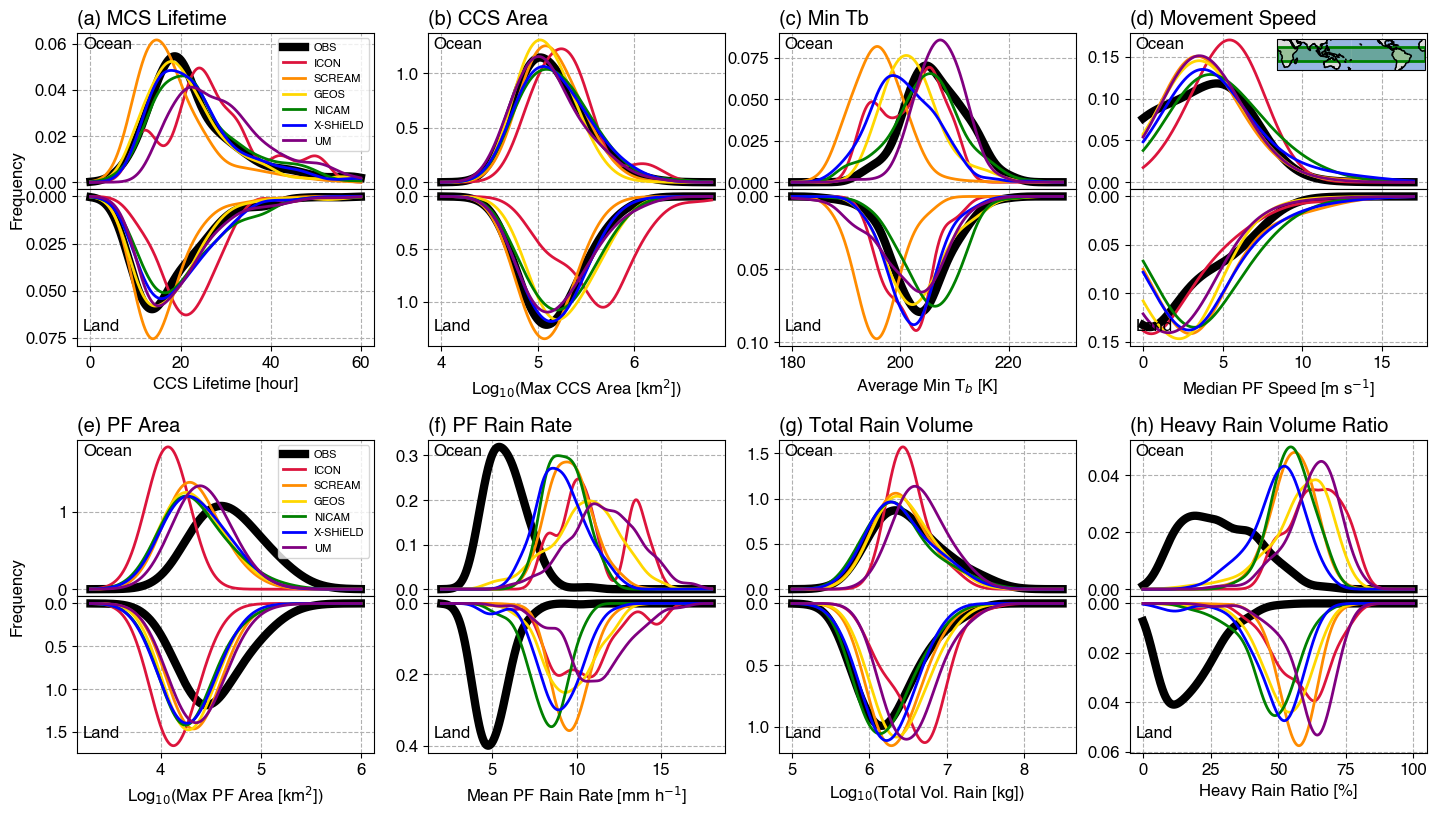

In [61]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_top = [
    [ccslifetime_o_dict, ccsarea_o_dict, mintb_o_dict, pfspeed_o_dict], 
    [pfarea_o_dict, pfrainrate_o_dict, volrain_o_dict, hrr_o_dict, ],
]
data_bot = [
    [ccslifetime_l_dict, ccsarea_l_dict, mintb_l_dict, pfspeed_l_dict], 
    [pfarea_l_dict, pfrainrate_l_dict, volrain_l_dict, hrr_l_dict, ],
]
titles = [
    ['(a) MCS Lifetime', '(b) CCS Area', '(c) Min Tb', '(d) Movement Speed'],
    ['(e) PF Area', '(f) PF Rain Rate', '(g) Total Rain Volume', '(h) Heavy Rain Volume Ratio'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'Median PF Speed [m s$^{-1}$]', ],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
label_topbot = ['Ocean', 'Land']
# figname = f'{figdir}kde1d_mcs_ocean_land_2x4_{region}.png'
figname = f'{figdir}kde1d_mcs_ocean_land_2x4_{region}.pdf'
fig = plot_pdf_mirror_mxn(2, 4, bins, data_top, data_bot, titles, xlabels, legends, figname,
                           map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,1],
                           legend_fontsize=8, legend_loc='best', label_topbot=label_topbot, figsize=[15,9])

In [62]:
figname

'/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures/kde1d_mcs_ocean_land_2x4_tropics.pdf'

## Function to plot 1D KDE on (m x n) panels

In [63]:
def plot_pdf_mxn(nrow, ncol, bins, data_arr, titles, xlabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                legend_fontsize=11, legend_loc='best', figsize=[10,10]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)

    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = axes[row][col]           
            ax.plot(bins[row][col], data_arr[row][col]['obs'], lcolors['obs'], lw=lw*3, label=legends['obs'])
            ax.plot(bins[row][col], data_arr[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            ax.plot(bins[row][col], data_arr[row][col]['m2'], lcolors['m2'], lw=lw, label=legends['m2'])
            ax.plot(bins[row][col], data_arr[row][col]['m3'], lcolors['m3'], lw=lw, label=legends['m3'])
            ax.plot(bins[row][col], data_arr[row][col]['m4'], lcolors['m4'], lw=lw, label=legends['m4'])
            ax.plot(bins[row][col], data_arr[row][col]['m5'], lcolors['m5'], lw=lw, label=legends['m5'])
            ax.plot(bins[row][col], data_arr[row][col]['m6'], lcolors['m6'], lw=lw, label=legends['m6'])
            # Labels
            if (col == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row][col])
            if (col == 0):
                ax.set_ylabel('Frequency')
            # ax.set_xticks(xticks[col])
            # ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                # borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-63-eda90850d272>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


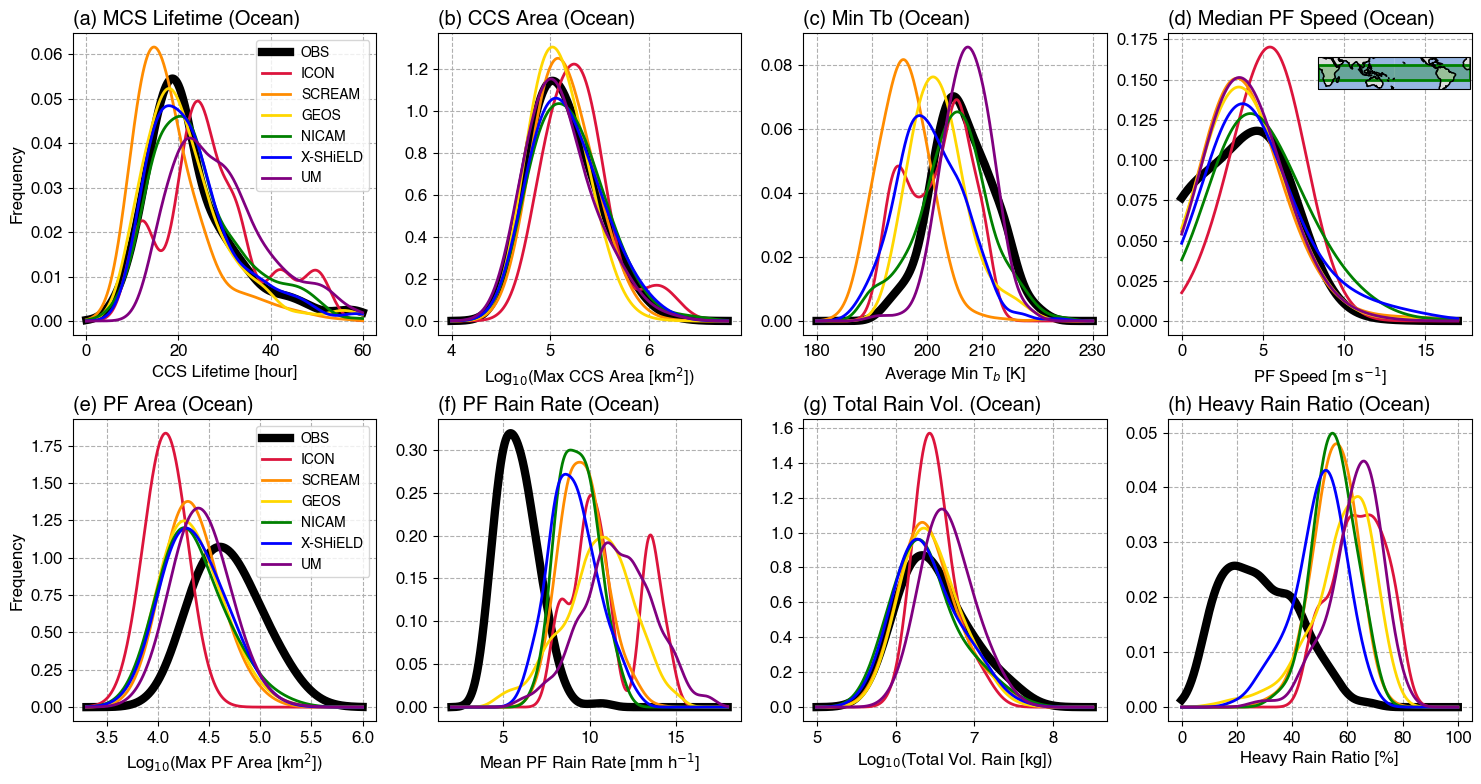

In [64]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_arr = [
    [ccslifetime_o_dict, ccsarea_o_dict, mintb_o_dict, pfspeed_o_dict], 
    [pfarea_o_dict, pfrainrate_o_dict, volrain_o_dict, hrr_o_dict, ],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)', '(d) Median PF Speed (Ocean)'],
    ['(e) PF Area (Ocean)', '(f) PF Rain Rate (Ocean)', '(g) Total Rain Vol. (Ocean)', '(h) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'PF Speed [m s$^{-1}$]'],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
figname = f'{figdir}kde1d_mcs_ocean_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[15,8])

<ipython-input-63-eda90850d272>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


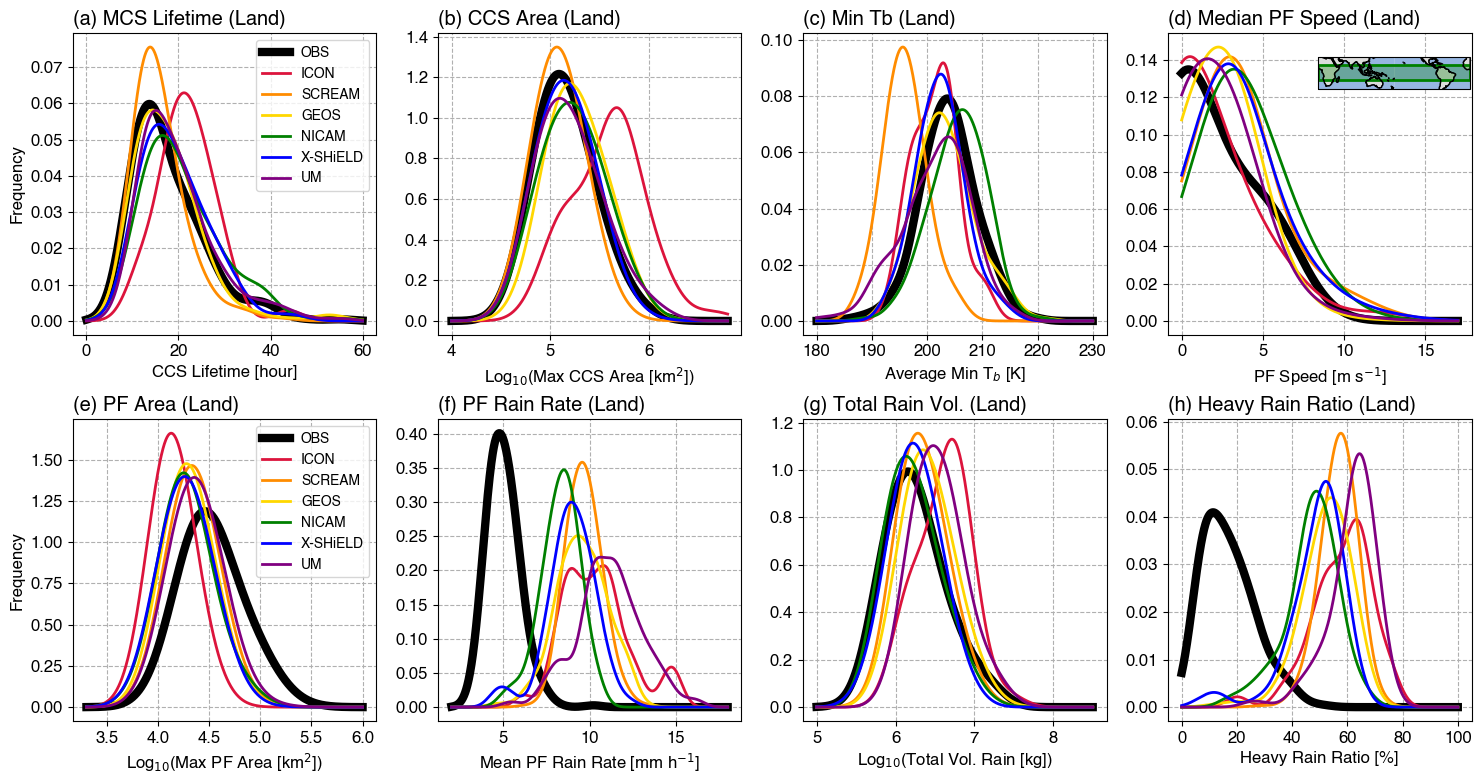

In [65]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_arr = [
    [ccslifetime_l_dict, ccsarea_l_dict, mintb_l_dict, pfspeed_l_dict], 
    [pfarea_l_dict, pfrainrate_l_dict, volrain_l_dict, hrr_l_dict, ],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)', '(d) Median PF Speed (Land)'],
    ['(e) PF Area (Land)', '(f) PF Rain Rate (Land)', '(g) Total Rain Vol. (Land)', '(h) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'PF Speed [m s$^{-1}$]'],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
figname = f'{figdir}kde1d_mcs_land_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[15,8])

In [66]:
figdir

'/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures/'

In [67]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [68]:
# Set Seaborn plot style
sns.set_theme('talk', style='whitegrid', font_scale=1.3, 
              rc={'lines.linewidth':5, 'font.family':'Helvetica', 'axes.edgecolor':'k', 'grid.linestyle':'--'})
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'k',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '--',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['Helvetica'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Function to plot 2D KDE

In [69]:
def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, 
                   legend_loc='lower right', legend_labels=None):
    mpl.rcParams['font.family'] = 'Helvetica'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    # legend_labels = ['OBS', f'{model_name[name_map["m1"]]}']
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')

    g.savefig(figname, dpi=300, facecolor='w')
    # sns.JointGrid(marginal_ticks=True)
    return g

## Ocean

In [70]:
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (0,60)
ylim = (4.8,7.6)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = 'Ocean'

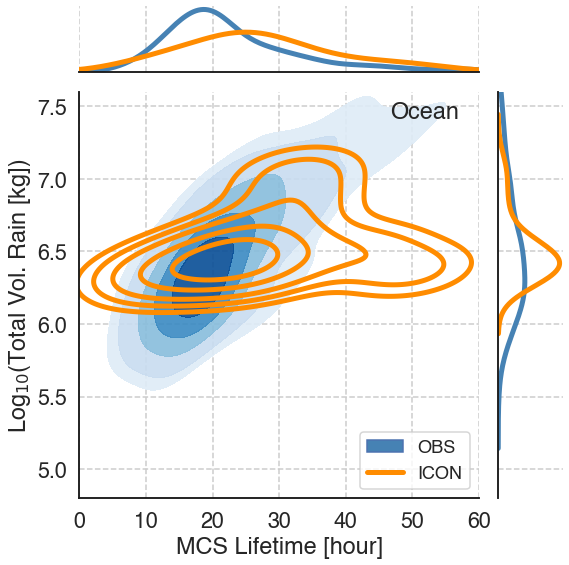

In [71]:
x_obs, y_obs = (ds_nms_o_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_o_obs).data
x_m1, y_m1 = (ds_nms_o_m1.track_duration * time_res_m1).data, np.log10(pfvolrain_o_m1).data
legend_labels = ['OBS', f'{model_name[name_map["m1"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_ocean_{name_map["m1"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

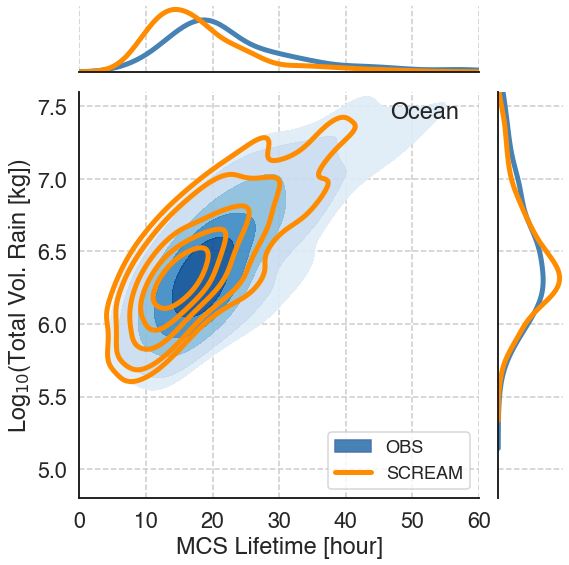

In [72]:
x_obs, y_obs = (ds_nms_o_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_o_obs).data
x_m2, y_m2 = (ds_nms_o_m2.track_duration * time_res_m2).data, np.log10(pfvolrain_o_m2).data
legend_labels = ['OBS', f'{model_name[name_map["m2"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_ocean_{name_map["m2"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m2, y_m2, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

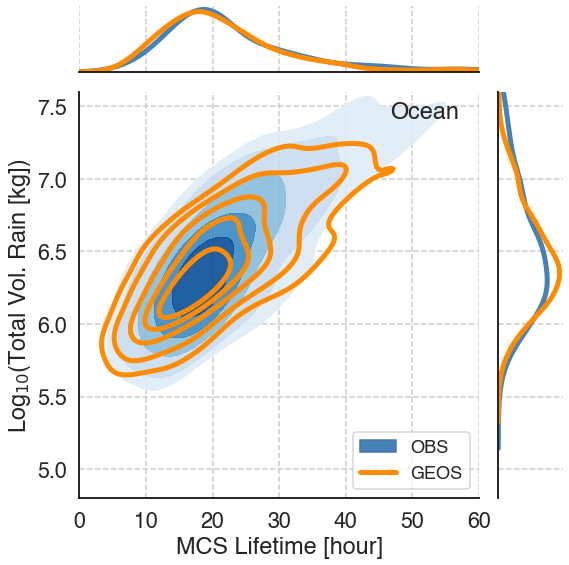

In [73]:
x_obs, y_obs = (ds_nms_o_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_o_obs).data
x_m3, y_m3 = (ds_nms_o_m3.track_duration * time_res_m3).data, np.log10(pfvolrain_o_m3).data
legend_labels = ['OBS', f'{model_name[name_map["m3"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_ocean_{name_map["m3"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m3, y_m3, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

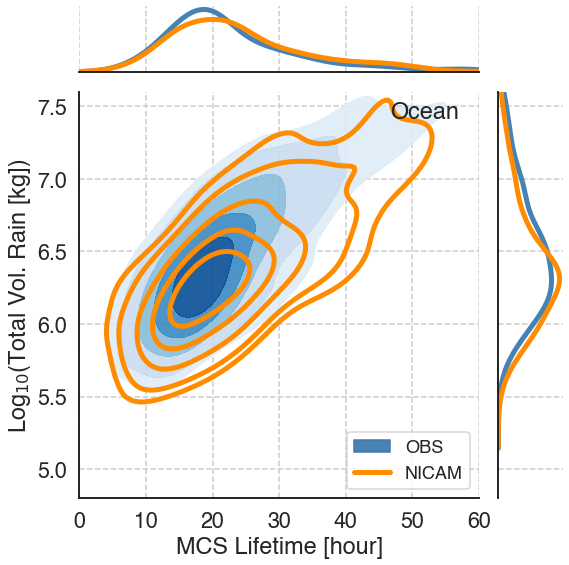

In [74]:
x_obs, y_obs = (ds_nms_o_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_o_obs).data
x_m4, y_m4 = (ds_nms_o_m4.track_duration * time_res_m4).data, np.log10(pfvolrain_o_m4).data
legend_labels = ['OBS', f'{model_name[name_map["m4"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_ocean_{name_map["m4"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m4, y_m4, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

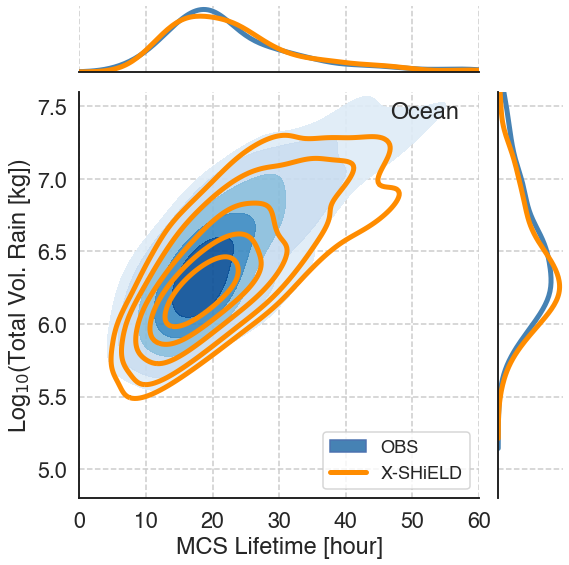

In [75]:
x_obs, y_obs = (ds_nms_o_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_o_obs).data
x_m5, y_m5 = (ds_nms_o_m5.track_duration * time_res_m5).data, np.log10(pfvolrain_o_m5).data
legend_labels = ['OBS', f'{model_name[name_map["m5"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_ocean_{name_map["m5"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m5, y_m5, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

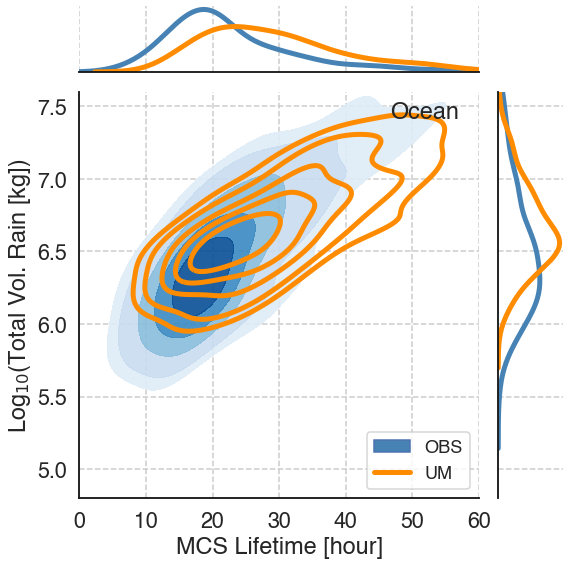

In [76]:
x_obs, y_obs = (ds_nms_o_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_o_obs).data
x_m6, y_m6 = (ds_nms_o_m6.track_duration * time_res_m6).data, np.log10(pfvolrain_o_m6).data
legend_labels = ['OBS', f'{model_name[name_map["m6"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_ocean_{name_map["m6"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m6, y_m6, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

## Land

In [77]:
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (0,60)
ylim = (4.8,7.6)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = 'Land'

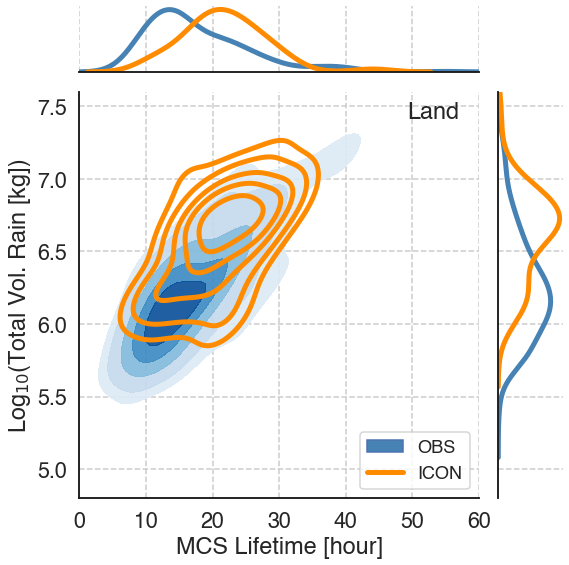

In [78]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m1, y_m1 = (ds_nms_l_m1.track_duration * time_res_m1).data, np.log10(pfvolrain_l_m1).data
legend_labels = ['OBS', f'{model_name[name_map["m1"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_{name_map["m1"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

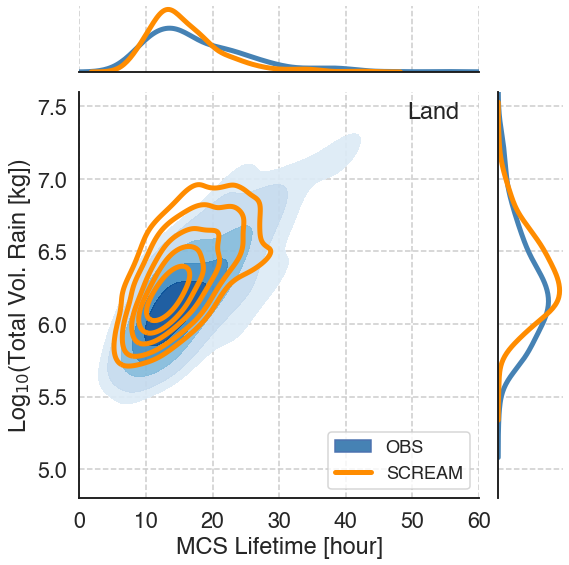

In [79]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m2, y_m2 = (ds_nms_l_m2.track_duration * time_res_m2).data, np.log10(pfvolrain_l_m2).data
legend_labels = ['OBS', f'{model_name[name_map["m2"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_{name_map["m2"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m2, y_m2, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

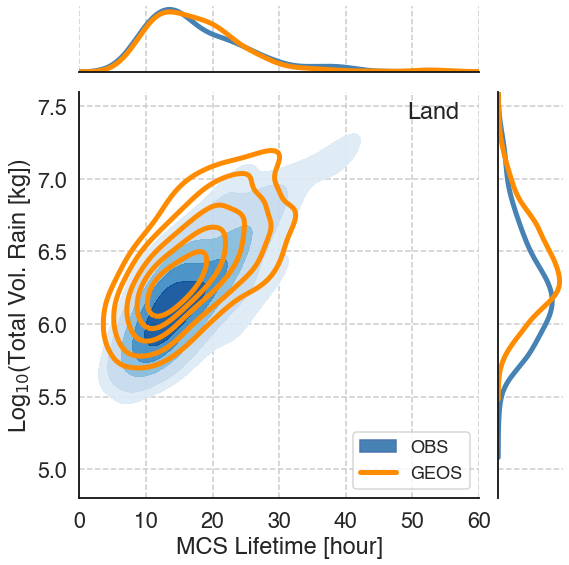

In [80]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m3, y_m3 = (ds_nms_l_m3.track_duration * time_res_m3).data, np.log10(pfvolrain_l_m3).data
legend_labels = ['OBS', f'{model_name[name_map["m3"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_{name_map["m3"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m3, y_m3, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

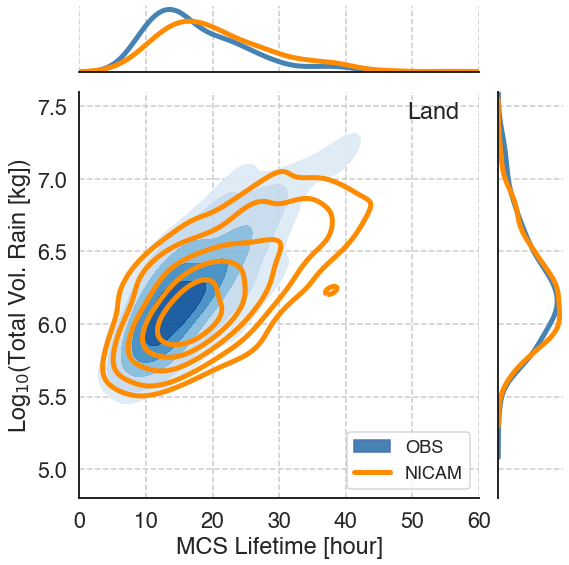

In [81]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m4, y_m4 = (ds_nms_l_m4.track_duration * time_res_m4).data, np.log10(pfvolrain_l_m4).data
legend_labels = ['OBS', f'{model_name[name_map["m4"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_{name_map["m4"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m4, y_m4, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

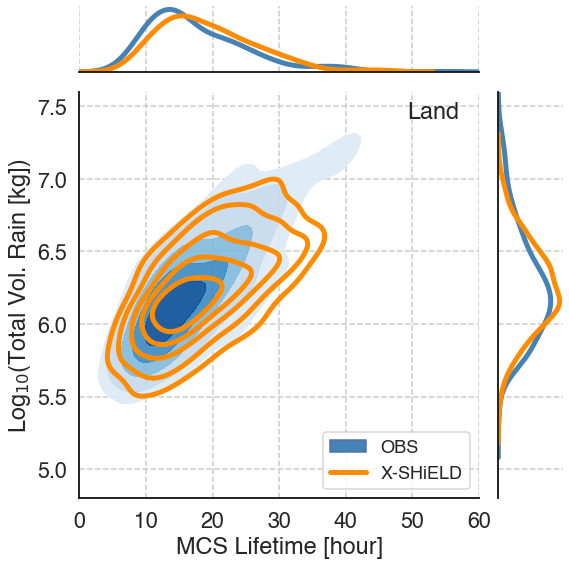

In [82]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m5, y_m5 = (ds_nms_l_m5.track_duration * time_res_m5).data, np.log10(pfvolrain_l_m5).data
legend_labels = ['OBS', f'{model_name[name_map["m5"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_{name_map["m5"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m5, y_m5, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

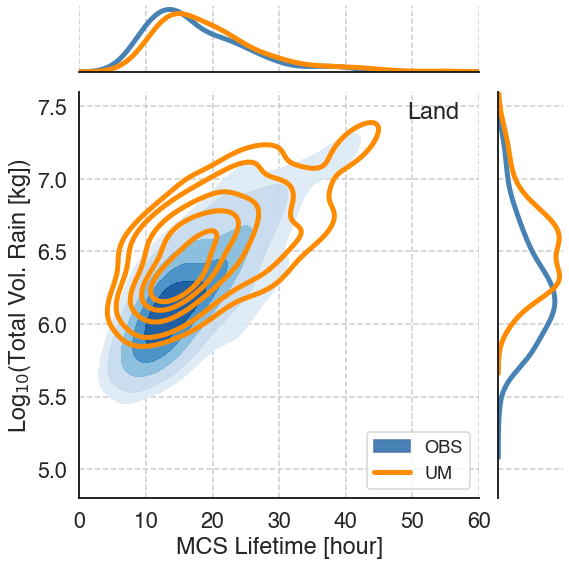

In [83]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m6, y_m6 = (ds_nms_l_m6.track_duration * time_res_m6).data, np.log10(pfvolrain_l_m6).data
legend_labels = ['OBS', f'{model_name[name_map["m6"]]}']
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_{name_map["m6"]}.png'
g = plot_jointdist(x_obs, y_obs, x_m6, y_m6, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)